## MobileNets

[*MobileNets*](https://arxiv.org/abs/1704.04861), as the name suggests, are neural networks constructed for the purpose of running very efficiently (high FPS, low memory footprint) on mobile and embedded devices. *MobileNets* achieve this with 3 techniques:

1. Perform a depthwise convolution followed by a 1x1 convolution rather than a standard convolution. The 1x1 convolution is called a pointwise convolution if it's following a depthwise convolution. The combination of a depthwise convolution followed by a pointwise convolution is sometimes called a separable depthwise convolution.
2. Use a "width multiplier" - reduces the size of the input/output channels, set to a value between 0 and 1.
3. Use a "resolution multiplier" - reduces the size of the original input, set to a value between 0 and 1.

These 3 techniques reduce the size of cummulative parameters and therefore the computation required. Of course, generally models with more paramters achieve a higher accuracy. *MobileNets* are no silver bullet, while they perform very well larger models will outperform them. ** *MobileNets* are designed for mobile devices, NOT cloud GPUs**. The reason we're using them in this lab is automotive hardware is closer to mobile or embedded devices than beefy cloud GPUs.

## *MobileNet* SSD

In this section you'll use a pretrained *MobileNet* [SSD](https://arxiv.org/abs/1512.02325) model to perform object detection. You can download the *MobileNet* SSD and other models from the [TensorFlow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) (*note*: we'll provide links to specific models further below). [Paper](https://arxiv.org/abs/1611.10012) describing comparing several object detection models.

Alright, let's get into SSD!

### Single Shot Detection (SSD)

Many previous works in object detection involve more than one training phase. For example, the [Faster-RCNN](https://arxiv.org/abs/1506.01497) architecture first trains a Region Proposal Network (RPN) which decides which regions of the image are worth drawing a box around. RPN is then merged with a pretrained model for classification (classifies the regions). The image below is an RPN:

![Faster-RCNN Visual](./assets/faster-rcnn.png)

The SSD architecture is a single convolutional network which learns to predict bounding box locations and classify the locations in one pass. Put differently, SSD can be trained end to end while Faster-RCNN cannot. The SSD architecture consists of a base network followed by several convolutional layers: 

![SSD Visual](./assets/ssd_architecture.png)

**NOTE:** In this lab the base network is a MobileNet (instead of VGG16.)

#### Detecting Boxes

SSD operates on feature maps to predict bounding box locations. Recall a feature map is of size $D_f * D_f * M$. For each feature map location $k$ bounding boxes are predicted. Each bounding box carries with it the following information:

* 4 corner bounding box **offset** locations $(cx, cy, w, h)$
* $C$ class probabilities $(c_1, c_2, ..., c_p)$

SSD **does not** predict the shape of the box, rather just where the box is. The $k$ bounding boxes each have a predetermined shape. This is illustrated in the figure below:

![](./assets/ssd_feature_maps.png)

The shapes are set prior to actual training. For example, In figure (c) in the above picture there are 4 boxes, meaning $k$ = 4.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
import random

from scipy.stats import norm
import cv2


#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

def preprocess(img):
    img = np.asarray(img)

    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(1,1))

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     V_channel = img[:,:,1]
#     img[:,:,1] = clahe.apply(img[:,:,1])
    img[:,:,2] = clahe.apply(img[:,:,2])
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return Image.fromarray(img)

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
SSD_GRAPH_FILE = 'ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
SSD_2_GRAPH_FILE = 'ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb'
RFCN_GRAPH_FILE = 'rfcn_resnet101_coco_11_06_2017/frozen_inference_graph.pb'
FASTER_RCNN_GRAPH_FILE = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017/frozen_inference_graph.pb'

detection_graph = load_graph(SSD_GRAPH_FILE)
# detection_graph = load_graph(RFCN_GRAPH_FILE)
# detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)
# detection_graph = load_graph(SSD_2_GRAPH_FILE)

# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

('Number of colors =', 148)


## Test detection code below

[10.]


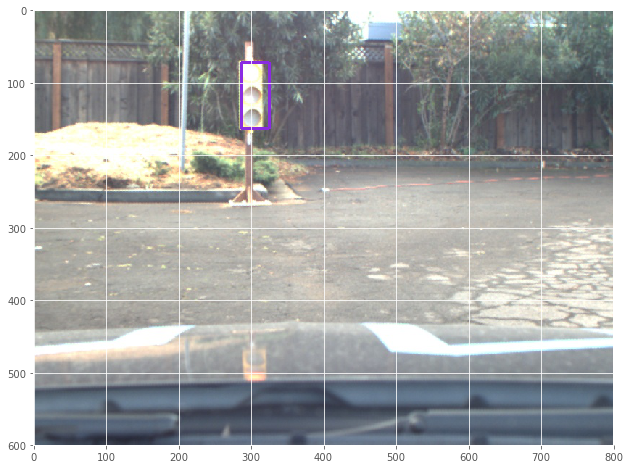

In [27]:

image = Image.open('./assets/sample4.jpg')
# image = preprocess(image)
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.3
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes)
#     print(detection_classes)
    print(classes)

    plt.figure(figsize=(12, 8))
    plt.imshow(image) 

## Parse label file format

In [52]:
import xml.etree.ElementTree as ET

# tree = ET.parse('xml/sim-green-1.xml')
# root = tree.getroot()
# bounding_boxes = []
# for child in root.findall('object'):
#     label = child.find('name').text
#     bounding_box = child.find('bndbox')
#     bounding_boxes.append([
#         int(bounding_box.find('xmin').text),
#         int(bounding_box.find('xmax').text),
#         int(bounding_box.find('ymin').text),
#         int(bounding_box.find('ymax').text)
#     ])

# print(bounding_boxes)

# def make_object(label, bndbox)

# def make_xml():

backgrounds = [
    'synthetic-data/backgrounds/bg-1.jpg',
    'synthetic-data/backgrounds/bg-2.jpg',
    'synthetic-data/backgrounds/bg-3.jpg',
    'synthetic-data/backgrounds/bg-4.jpg'
]
red = [
    'synthetic-data/elements/red-large.jpg',
    'synthetic-data/elements/red-medium.jpg',
    'synthetic-data/elements/red-small.jpg'
]
green = [
    'synthetic-data/elements/green-large.jpg',
    'synthetic-data/elements/green-medium.jpg',
    'synthetic-data/elements/green-small.jpg'
]
yellow = [
    'synthetic-data/elements/yellow-large.jpg',
    'synthetic-data/elements/yellow-medium.jpg',
    'synthetic-data/elements/yellow-small.jpg'
]

def create_object(wrapper, label, bounding_box):
    obj = ET.SubElement(wrapper, 'object')

    name = ET.SubElement(obj, 'name')
    name.text = label
    
    pose = ET.SubElement(obj, 'pose')
    pose.text = 'Unspecified'
    
    truncated = ET.SubElement(obj, 'truncated')
    truncated.text = str(0)
    
    difficult = ET.SubElement(obj, 'difficult')
    difficult.text = str(0)

    bndbox = ET.SubElement(obj, 'bndbox')

    xmin = ET.SubElement(bndbox, 'xmin')
    xmin.text = str(bounding_box[0])

    ymin = ET.SubElement(bndbox, 'ymin')
    ymin.text = str(bounding_box[1])

    xmax = ET.SubElement(bndbox, 'xmax')
    xmax.text = str(bounding_box[2])

    ymax = ET.SubElement(bndbox, 'ymax')
    ymax.text = str(bounding_box[3])

def create_xml(name, width, height, label, bounding_boxes):
    annotation = ET.Element('annotation')
    
    filename = ET.SubElement(annotation, 'filename')
    filename.text = name
    
    size = ET.SubElement(annotation, 'size')

    w = ET.SubElement(size, 'width')
    w.text = str(width)

    h = ET.SubElement(size, 'height')
    h.text = str(height)

    depth = ET.SubElement(size, 'depth')
    depth.text = str(3)
    
    segmented = ET.SubElement(annotation, 'segmented')
    segmented.text = str(0)
    
    for i in range(len(bounding_boxes)):
        create_object(annotation, label, bounding_boxes[i])
    return annotation
    
def add_to_image(bg, img_set, num):
    bounding_boxes = []
    for num_light in range(random.randint(1, num)):
        synth_image = Image.open(img_set[random.randint(0, 2)])
        light_width, light_height = synth_image.size
        
        upper_left_x = random.randint(-light_width / 2, bg_width - light_width / 2)
        upper_left_y = random.randint(-light_width / 2, bg_height + light_height / 2)
        
        bg.paste(synth_image, (upper_left_x, upper_left_y))
        # bounding box is in the format xmin, ymin, xmax, ymax
        bounding_boxes.append([
            upper_left_x,
            upper_left_y + light_height,
            upper_left_x + light_width,
            upper_left_y
        ])
    return bounding_boxes

# at most we want the light half-obscured
for i in range(10):
    filename = 'synthetic-green-' + str(i)
    bg = Image.open(backgrounds[random.randint(0, 3)])
    bg_width, bg_height = bg.size
    bounding_boxes = add_to_image(bg, green, 10)
    annotation = create_xml(filename + '.jpg', bg_width, bg_height, 'Green_light', bounding_boxes)
    ET.ElementTree(annotation).write('output/' + filename + '.xml')
    bg.save('output/' + filename + '.jpg')

#     plt.imshow(bg)

### Starter jitter code (generate more training data)

From [github](https://github.com/thegleb/CarND-Traffic-Sign-Classifier-Project). Originally used to process pretty small images; since our input images are bigger here, we probably should apply larger transforms.

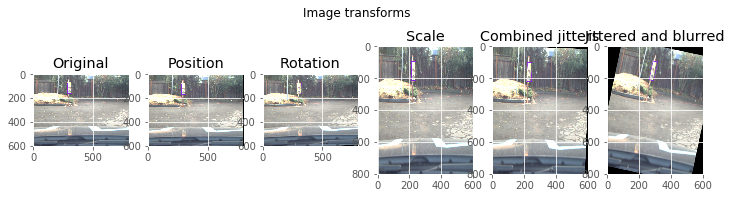

In [30]:
def jitter_position(img):
    """
    Randomly shift the image by up to 10 pixels in the x and/or y directions
    """
    x_d = random.randint(-10, 10)
    y_d = random.randint(-10, 10)
    rows, cols, channels = img.shape
    M = np.float32([[1, 0, x_d],[0, 1, y_d]])

    return cv2.warpAffine(img, M, (cols, rows))

def jitter_rotation(img):
    """
    Randomly rotate the image between -15 and 15 degrees
    """
    rows, cols, channels = img.shape
    angle = random.randint(-15, 15)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)

    return cv2.warpAffine(img, M, (cols, rows))

def jitter_scale(img):
    """
    Randomly change the scale of the image in both x and y directions
    """
    x_scale = random.uniform(0.9, 1.1)
    y_scale = random.uniform(0.9, 1.1)
    rows, cols, channels = img.shape
    zeroed_image = np.zeros_like(img)
    return cv2.resize(img, (img.shape[0],img.shape[1]), fx=x_scale, fy=y_scale, interpolation = cv2.INTER_CUBIC)

def blur(img):
    """
    Simple gaussian blur
    """
    return cv2.GaussianBlur(img,(5,5),0)

def jitter(img):
    """
    Combine all the jitter transforms together
    """
    return jitter_position(jitter_rotation(jitter_scale(img)))

def visualize(img, title=''):
    """
    Plot image data
    """
    fig, ax = plt.subplots()
    if img.shape[2] is 1:
        # this might not actually work
        ax.imshow(np.dstack([img[0], img[0], img[0]]), cmap='gray', vmin=0, vmax=255)
    else:
        ax.imshow(img)
    ax.set_title(title)
    plt.show()

sample_img = np.asarray(image, dtype=np.uint8)

transformed_images = [
    [sample_img, 'Original'],
    [jitter_position(sample_img), 'Position'],
    [jitter_rotation(sample_img), 'Rotation'],
    [jitter_scale(sample_img), 'Scale'],
    [jitter(sample_img), 'Combined jitters'],
    [blur(jitter(sample_img)), 'Jittered and blurred'],
]

fig, axs = plt.subplots(1, len(transformed_images))
fig.set_size_inches(12, 3)
fig.suptitle('Image transforms')
for i in range(len(transformed_images)):
    transformed_img, label = transformed_images[i]
    axs[i].set_title(label)
    axs[i].imshow(transformed_img)

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [4]:
def time_detection(sess, img_height, img_width, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')

    # warmup
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [5]:
with tf.Session(graph=detection_graph) as sess:
    times = time_detection(sess, 600, 1000, runs=10)

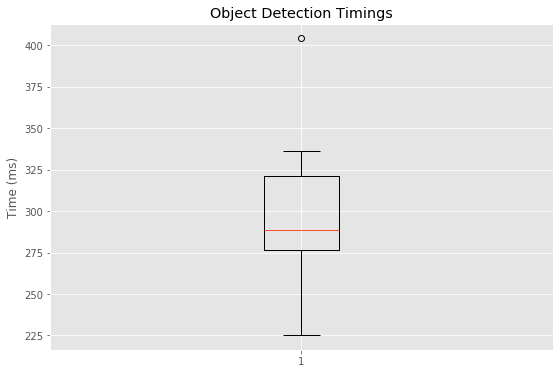

In [10]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)

### Exercise 4 - Model Tradeoffs

Download a few models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) and compare the timings.

## Detection on a Video

Finally run your pipeline on [this short video](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/advanced_deep_learning/driving.mp4).

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('driving.mp4'))

### Exercise 5 - Object Detection on a Video

Run an object detection pipeline on the above clip.

In [13]:
clip = VideoFileClip('driving.mp4')

In [29]:
# TODO: Complete this function.
# The input is an NumPy array.
# The output should also be a NumPy array.
def pipeline(img):
    draw_img = Image.fromarray(img)
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: np.expand_dims(img, 0)})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.3
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = draw_img.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(draw_img, box_coords, classes)
    return np.array(draw_img)

**[Sample solution](./exercise-solutions/e5.py)**

In [30]:
with tf.Session(graph=detection_graph) as sess:
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    new_clip = clip.fl_image(pipeline)
    
    # write to file
    new_clip.write_videofile('result.mp4', audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|██████████| 1782/1782 [07:31<00:00,  3.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [26]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('result.mp4'))

## Further Exploration

Some ideas to take things further:

* Finetune the model on a new dataset more relevant to autonomous vehicles. Instead of loading the frozen inference graph you'll load the checkpoint.
* Optimize the model and get the FPS as low as possible.
* Build your own detector. There are several base model pretrained on ImageNet you can choose from. [Keras](https://keras.io/applications/) is probably the quickest way to get setup in this regard.
